# CNN-based Brain Tumour Classification
## Import packages
Please make sure you have all the required packages installed. If GPU is available, but you want to use CPU to train your model, make sure you add " os.environ['CUDA_VISIBLE_DEVICES'] = '-1' " before "from keras.preprocessing.image import ImageDataGenerator"

In [1]:
import numpy as np 
from tqdm import tqdm
import os
import random
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import shutil
import tensorflow

from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

## Data preparation (this step has been done for you)

Images in the original dataset are usually in different sizes, so we need to resize and normalise them to fit the CNN model. Depending on the images you choose to use for training your model, some other preprocessing methods (cropping, zooming, etc.) may be required.


## Split your dataset into training and validation
Validation dataset would not be used to train your network, it is normally for evaluating your model performance and choosing the best set of hyperparameters. Choose the size of your training and validation set yourself.

In [5]:
#uncomment if using linux/macos
# !rm -rf Train Val
# !mkdir Train Val Train/Yes Train/No Val/Yes Val/No

#uncomment if using windows
!rmdir Train Val /s /q
!md Train Val Train\Yes Train\No Val\Yes Val\No


img_path = 'Dataset/'
train_list = []
val_list = []
for CLASS in os.listdir(img_path):
    if not CLASS.startswith('.'):
        all_files = os.listdir(img_path + CLASS)
        files = [item for item in all_files if "img" in item]
        random.shuffle(files)
        img_num = len(files)
        for (n, file_name) in enumerate(files):
            img = os.path.join(img_path,CLASS,file_name)
            seg = os.path.join(img_path,CLASS,file_name.split('_')[0]+'_seg.npy')
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*img_num:
                shutil.copy(img, os.path.join('Train/',CLASS,file_name))
                train_list.append(os.path.join('Train/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Train/',CLASS,file_name.split('_')[0]+'_seg.npy'))
            else:
                shutil.copy(img, os.path.join('Val/',CLASS,file_name))
                val_list.append(os.path.join('Val/',CLASS,file_name))
                shutil.copy(seg, os.path.join('Val/',CLASS,file_name.split('_')[0]+'_seg.npy'))


## Plot images
Plot some sample images here.

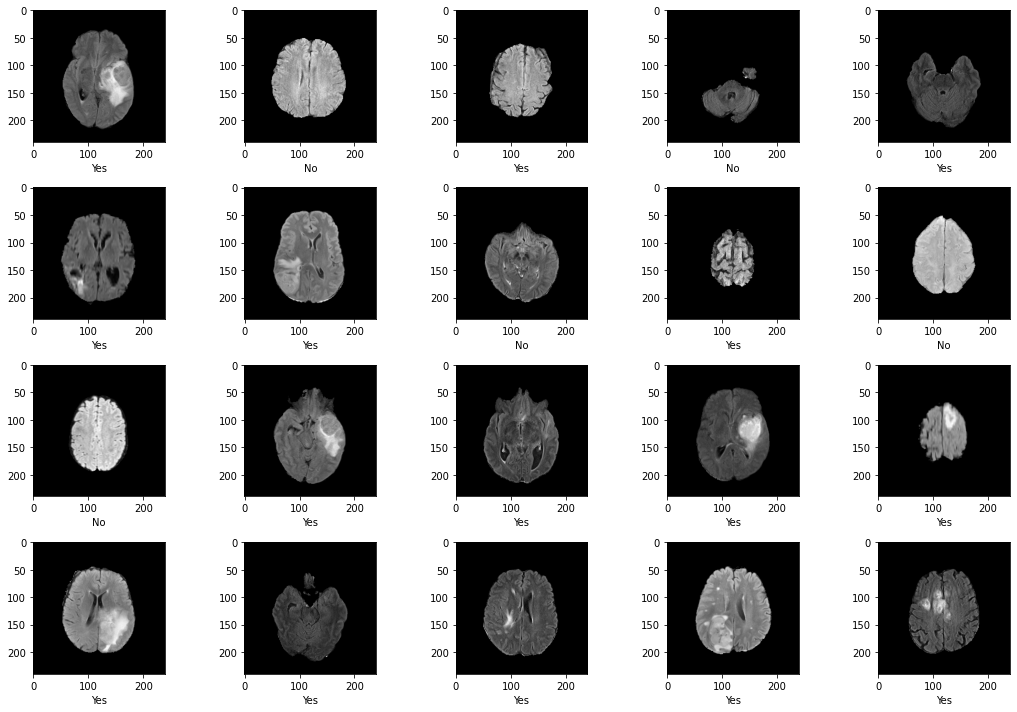

In [6]:
def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, all_files in os.walk(img_path):
        files = [item for item in all_files if "img" in item]
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = np.load(file)
        plt.subplot(i,j,k)
        plt.imshow(img[:,:,0], cmap='gray')
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(img_path)

## Train-time data augmentation
Generalizability is crucial to a deep learning model and it refers to the performance difference of a model when evaluated on the seen data (training data) versus the unseen data (testing data). Improving the generalizability of these models has always been a difficult challenge. 

<img src="files/img.jpg">


**Data Augmentation** is an effective way of improving the generalizability, because the augmented data will represent a more comprehensive set of possible data samples and minimizing the distance between the training and validation/testing sets.

There are many data augmentation methods you can choose in this projects including rotation, shifting, flipping, etc.

You are encouraged to try different augmentation method to get the best classification accuracy.

**Question**

Applying data augmentation to medical images may sometimes make the images uninterpretable to human. For instance, a heart may not look like a heart after shearing the image. Would training the model with these uninterpretable images helpful to improving the model performance? Why do you think it is helpful/not helpful?

## Get the data generator ready

You may change the batch size of your training data here. A large batch size or even a batch size that equals to the entire dataset is more likely to get your model to the convergence to the global optima of the loss function, but this is at the cost of computational efficiency and sometimes large batch size would lead to a bad model generalisation. 

There is always a trade-off between large and small batch size. Choose a reasonable batch size here to get the best model performance.

You can add your data augmentation methods here. Some simple example can be found at https://towardsdatascience.com/image-augmentation-using-python-numpy-opencv-and-skimage-ef027e9898da.

In [7]:
class DataGenerator(tensorflow.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=32, dim=(240,240), n_channels=3,
                 n_classes=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(list_IDs_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            # Add data augmentation here
            X[i,] = np.load(ID)

            # Store class
            y[i] = min(1,np.sum(np.load(ID.split('_')[0]+'_seg.npy')))

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [8]:
train_generator = DataGenerator(train_list)
validation_generator = DataGenerator(val_list)
img_size = (240,240)

## Load the backbone model

To extract the features from the dataset, a backbone network is used here. Initially, VGG16 is used here as an example.

To achieve the best classification accuracy, you are encouraged to try different models. A list of models you can try is given at https://keras.io/api/applications/. Remember to update the **Preparing your environment** and **this** part to use a different backbone model, for instance, to use the ResNet50 as the backbone network, change 'from keras.applications.vgg16 import VGG16, preprocess_input' into 'from keras.applications.resnet_v2 import ResNet50, preprocess_input'

These models are pretrained on ImageNet dataset for classification task and you can choose to finetune the pretrained network (transfer learning: https://papers.nips.cc/paper/5347-how-transferable-are-features-in-deep-neural-networks.pdf) or train it from the scratch for the tumour classification task.

VGG16: https://arxiv.org/pdf/1409.1556

ResNet: https://arxiv.org/abs/1512.03385

DenseNet: https://arxiv.org/abs/1608.06993

**Question**

What are the advantages and disadvantages of finetuning a model for tumour classification?

In [10]:
base_model = VGG16(
    #uncomment if you want to train your network from scratch.
    weights = None,
    include_top=False, 
    input_shape=img_size+(3,)
)

## Build the model for tumour classification

A classifier is added to the backbone network here. The loss function used to train the model is binary cross entropy (details can be found at https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class and https://machinelearningmastery.com/cross-entropy-for-machine-learning/). 

The optimizer used here is ADAM (https://arxiv.org/abs/1412.6980) and you can leave it unchanged.

In [11]:
num_classes = 2

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout (Dropout)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 50178     
Total params: 14,764,866
Trainable params: 14,764,866
Non-trainable params: 0
_________________________________________________________________


## Train the model
The early stopping would stop the training process when a pre-defined metric stops improving. More details can be found at https://keras.io/api/callbacks/early_stopping/.

In [ ]:
num_epochs = 12
earlystopping = EarlyStopping(
    monitor='accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)

Train for 134 steps, validate for 33 steps
Epoch 1/12
134/134 [==============================] - 91s 677ms/step - loss: 0.2011 - accuracy: 0.9163 - val_loss: 0.2058 - val_accuracy: 0.9105
Epoch 2/12
134/134 [==============================] - 106s 793ms/step - loss: 0.1936 - accuracy: 0.9260 - val_loss: 0.1902 - val_accuracy: 0.9295
Epoch 3/12
134/134 [==============================] - 108s 807ms/step - loss: 0.1923 - accuracy: 0.9234 - val_loss: 0.1945 - val_accuracy: 0.9242
Epoch 4/12
134/134 [==============================] - 108s 805ms/step - loss: 0.1751 - accuracy: 0.9330 - val_loss: 0.1930 - val_accuracy: 0.9323
Epoch 5/12
134/134 [==============================] - 110s 822ms/step - loss: 0.1583 - accuracy: 0.9370 - val_loss: 0.1834 - val_accuracy: 0.9318
Epoch 6/12
134/134 [==============================] - 127s 945ms/step - loss: 0.1342 - accuracy: 0.9476 - val_loss: 0.2049 - val_accuracy: 0.9304
Epoch 7/12
134/134 [==============================] - 127s 949ms/step - loss: 0.13

## Plot training result##

**Question**

What causes the gap between training accuracy/loss and test accuracy/loss? How do you reduce the gap between training accuracy/loss and test accuracy/loss?

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Save your trained model
If you feel your model has been trained to convergence, save it here.

In [ ]:
model.save('trained_model.h5')

## Test the model (For last project Q&A session)
Test your trained model here.

In [ ]:
test_dir = 'Test/'
#load your model here
model = load_model('trained_model.h5')
test_list = []
for CLASS in os.listdir(test_dir):
    if not CLASS.startswith('.'):
        all_files = os.listdir(test_dir + CLASS)
        files = [item for item in all_files if "img" in item]
        for file_name in files:
            test_list.append(test_dir + CLASS + '/' + file_name)
test_generator = DataGenerator(test_list, batch_size=1)

predictions = []
y_test = []
for i in range(test_generator.__len__()):
    x_test, y = test_generator.__getitem__(i)
    y_test.append(y[0][1])
    prediction = model.predict(x_test)
    predictions.append(np.int(prediction[0][1]>0.5))
accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

## Covid19
You can also try to classify lung CT images with or without infection. 

In [ ]:
!rm -rf Train_covid Val_covid
!mkdir Train_covid Val_covid Train_covid/yes Train_covid/no Val_covid/yes Val_covid/no
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input


IMG_PATH = 'covid19/'
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        files = os.listdir(IMG_PATH + CLASS)
        random.shuffle(files)
        IMG_NUM = len(files)
        for (n, FILE_NAME) in enumerate(files):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            # 80% of images will be used for training, change the number here 
            # to use different number of images for training your model.
            if n < 0.8*IMG_NUM:
                shutil.copy(img, 'Train_covid/'+ CLASS + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'Val_covid/'+ CLASS + '/' + FILE_NAME)


def plot_samples(img_path,n=20):
    files_list = []
    labels_list = []
    for path, subdirs, files in os.walk(img_path):
        for name in files:
            files_list.append(os.path.join(path, name))
            labels_list.append(path.split('/')[1])
    imgs_lbls = list(zip(files_list, labels_list))
    random.shuffle(imgs_lbls)
    files_list, labels_list = zip(*imgs_lbls)
    j = 5
    i = int(n/j)
    plt.figure(figsize=(15,10))
    k = 1
    for file, lbl in zip(files_list[:n], labels_list[:n]):
        img = cv2.imread(file)
        plt.subplot(i,j,k)
        plt.imshow(img)
        plt.xlabel(lbl)
        k += 1
    plt.tight_layout()
    plt.show()
    
plot_samples(IMG_PATH)

TRAIN_DIR = 'Train_covid/'
VAL_DIR = 'Val_covid/'
IMG_SIZE = (224,224)
RANDOM_SEED = 100

train_datagen = ImageDataGenerator(
    #add your augmentation methods here
    #rotation_range=15,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    interpolation='bicubic',
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


base_model = VGG16(
    #uncomment if you want to train your network from scratch.
    #weight = None
    include_top=False, 
    input_shape=IMG_SIZE + (3,)
)

NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

# uncomment here if you want to finetune the top layer(classifier) of a pretrained network only. 
# model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

num_epochs = 200
earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=20
)

history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=[earlystopping]
)

## Validation

In [ ]:
def load_data(dir_path, img_size=IMG_SIZE):
    X = []
    y = []
    i = 0
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    img = cv2.resize(img, dsize=img_size, interpolation=cv2.INTER_CUBIC)
                    X.append(preprocess_input(img))
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y

X_val, y_val = load_data(VAL_DIR)
predictions = model.predict(X_val)
print(predictions)
predictions = [1 if x>0.5 else 0 for x in predictions]
accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)